In [2]:
!pip install livelossplot
!pip install wandb

import os
import math
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import functools
import optax
import itertools
import random
import time
import wandb
import optax


from jax import grad, jit, vmap
from livelossplot import PlotLosses


if os.environ["COLAB_GPU"] and int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
else:
    print("Only CPU accelerator is connected.")
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

a GPU is connected.
gpu


In [20]:
class SequenceToQKV(nn.Module):
  output_size: int

  @nn.compact
  def __call__(self, X):
    initializer = nn.initializers.variance_scaling(scale=0.5, mode="fan_in", distribution="truncated_normal")

    q_layer = nn.Dense(self.output_size, kernel_init=initializer)
    k_layer = nn.Dense(self.output_size, kernel_init=initializer)
    v_layer = nn.Dense(self.output_size, kernel_init=initializer)

    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

In [21]:
class MultiHeadAttention(nn.Module):

  d_m: int
  num_heads: int

  def setup(self):
    initializer = nn.initializers.variance_scaling(scale=0.5, mode="fan_in", distribution="truncated_normal")
    self.d_k  = self.d_m // self.num_heads

    self.W_q = nn.Dense(self.d_m, kernel_init=initializer)
    self.W_k = nn.Dense(self.d_m, kernel_init=initializer)
    self.W_v = nn.Dense(self.d_m, kernel_init=initializer)
    self.Wo  = nn.Dense(self.d_m, kernel_init=initializer)
    self.sequence_to_qkv = SequenceToQKV(self.d_m)

  def scaled_dot_product_attention(self,query, key, value, mask=None):
    d_k = key.shape[-1]
    T_k = key.shape[-2]
    T_q = query.shape[-2]
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
    scaled_logits = logits/jnp.sqrt(d_k)
    if mask is not None:
      scaled_logits = jnp.where(mask[:T_q, :T_k], scaled_logits, -jnp.inf)
    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)
    attention = jnp.matmul(attention_weights, value)
    return attention, attention_weights

  def __call__(self, X, mask=None):

    # get the batch size, sequence length and embedding size
    Q, K, V   = self.sequence_to_qkv(X)
    B, T, d_m = K.shape
    assert d_m == self.d_m


    q_heads = Q.reshape(B, -1, self.num_heads, self.d_k).swapaxes(1,2)
    k_heads = K.reshape(B, -1, self.num_heads, self.d_k).swapaxes(1,2)
    v_heads = V.reshape(B, -1, self.num_heads, self.d_k).swapaxes(1,2)

    # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, d_m) - re-assemble all head outputs
    attention, attention_weights = self.scaled_dot_product_attention(
        q_heads, k_heads, v_heads, mask
        )

    attention = attention.swapaxes(1,2).reshape(B, -1, d_m)
    X_new = self.Wo(attention)
    return X_new, attention_weights




In [6]:
class PositionalEncoding(nn.Module):

    d_m: int
    max_seq_length: int

    def setup(self):
        pe = jnp.zeros((self.max_seq_length, d_m))
        positions = jnp.arange(0, self.max_seq_length)[: jnp.newaxis]

        i = jnp.arange(0, d_m, 2)
        div_term = jnp.exp(i * (-math.log(10000.0) / d_m))
        frequencies = positions * div_term

        pe = pe.at[:, 0::2].set(jnp.sin(frequencies))
        pe = pe.at[:, 1::2].set(jnp.cos(frequencies))
        self.pe  = pe

    def __call__(self, x):
      return x + self.pe[:x.shape[0], :]

def positionalEncoding(d_m,sequence_length):
      assert d_m % 2 == 0, "token_embedding should be divisible by two"

      pe = jnp.zeros((sequence_length, d_m))
      positions = jnp.arange(0, sequence_length)[:, jnp.newaxis]

      i = jnp.arange(0, d_m, 2)
      div_term = jnp.exp(i * (-math.log(10000.0) / d_m))
      frequencies = positions * div_term

      pe = pe.at[:, 0::2].set(jnp.sin(frequencies))
      pe = pe.at[:, 1::2].set(jnp.cos(frequencies))
      return pe


In [7]:
class FeedForward(nn.Module):
  """
  A 2-layer MLP which widens then narrows the input.

  Args:
    widening_factor [optional, default=4]: The size of the hidden layer will be d_model * widening_factor.
  """

  widening_factor: int = 4
  init_scale: float = 0.25

  @nn.compact
  def __call__(self, x):
    '''
    Args:
      x: [B, T, d_m]

    Return:
      x: [B, T, d_m]
    '''
    d_m = x.shape[-1]
    layer1_size = self.widening_factor * d_m

    initializer = nn.initializers.variance_scaling(
        scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
    )
    layer1 = nn.Dense(layer1_size, kernel_init=initializer)
    layer2 = nn.Dense(d_m, kernel_init=initializer)

    x = jax.nn.gelu(layer1(x))
    x = layer2(x)
    return x

In [8]:
class AddNorm(nn.Module):
  """A block that impliments the add and norm block"""

  @nn.compact
  def __call__(self, x, processed_x):
    '''
    Args:
      x: Sequence of tokens before feeding into MHA or FF blocks, with shape [B, T, d_m]
      x: Sequence of after being processed by MHA or FF blocks, with shape [B, T, d_m]

    Return:
      add_norm_x: Transformed tokens with shape [B, T, d_m]
    '''

    added = x + processed_x
    normalised = nn.LayerNorm(reduction_axes=-1, use_scale=True, use_bias=True)
    return normalised(added)

In [9]:
class DecoderBlock(nn.Module):

  d_m: int
  num_heads: int
  ff_widening_factor: int
  dropout_rate: float
  training: bool
  pre_norm: bool

  def setup(self):
    self.mha = MultiHeadAttention(d_m = self.d_m, num_heads = self.num_heads)
    self.add_norm1 = AddNorm()
    self.ff = FeedForward(widening_factor=self.ff_widening_factor)
    self.add_norm2 = AddNorm()
    self.dropout = nn.Dropout(rate=self.dropout_rate)

  def __call__(self, X, mask=None, key=None):

      x_output = None
      attention_weights = None

      if not self.pre_norm:
        attention_output, attention_weights = self.mha(X=X,mask=mask)
        add_norm1_output = self.add_norm1(X, self.dropout(attention_output, deterministic=not self.training, rng=key))
        ff_output = self.ff(add_norm1_output)
        add_norm2_output = self.add_norm2(add_norm1_output, self.dropout(ff_output, deterministic=not self.training, rng=key))
        x_output = add_norm2_output
      else:
        X = self.add_norm1(X,X)
        attention_output, attention_weights = self.mha(X=X,mask=mask)
        add_norm2_output = self.add_norm2(X, self.dropout(attention_output, deterministic=not self.training, rng=key))
        ff_output = self.ff(add_norm2_output)
        x_output = self.dropout(ff_output, deterministic=not self.training, rng=key)

      return x_output, attention_weights



In [10]:
class LM(nn.Module):


    num_heads:int
    num_layers:int
    d_m:int
    ff_widening_factor:int
    vocab_size: int
    dropout_rate: float
    training: bool
    pre_norm: bool
    tie_weights: bool

    def setup(self):
        self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.d_m) # convert tokens to embeddings
        self.decoder_blocks = [DecoderBlock(self.d_m, self.num_heads, self.ff_widening_factor, self.dropout_rate, self.training, self.pre_norm) for _ in range(self.num_layers)]
        self.pred_layer = nn.Dense(self.vocab_size)
        self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, mask=None, key=None):
        x = self.embedding(x)
        sequence_len = x.shape[-2]
        positions = positionalEncoding(self.d_m,sequence_len)
        x = x + positions
        attention_weights = []
        for decoder_block in self.decoder_blocks:
            key, subkey = jax.random.split(key)
            out, attention_weight = decoder_block(x, mask, key=subkey)
            out = self.dropout(out, deterministic=not self.training, rng=key)
            x = out
            attention_weights.append(attention_weight)

        logits = None
        if self.tie_weights:
            logits = nn.log_softmax(x @ self.embedding.embedding.T)
        else:
          logits = nn.log_softmax(self.pred_layer(x))

        return logits, attention_weights



In [11]:
B, T, d_m, N, vocab_size = 18, 32, 16, 8, 25670

lm = LM(num_heads=1, num_layers=1, d_m=d_m, vocab_size=vocab_size, ff_widening_factor=4,
        dropout_rate=0.1, training=True,
        pre_norm=False,
        tie_weights=False
        )
key = jax.random.PRNGKey(90)
mask = jnp.tril(np.ones((T, T)))

# initialise module and get dummy output
key = jax.random.PRNGKey(90)
X = jax.random.randint(key, [B, T], 0, vocab_size)
params = lm.init(key, X, mask=mask, key=key)

# extract output from decoder
logits, decoder_att_weights = lm.apply(
    params,
    X,
    mask=mask,
    key = key
)

# **Training Language Model**

In [12]:
class CharacterBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into characters
        characters = list(corpus)
        self.vocab_size = len(set(characters))  # Number of unique words

        # Create a mapping from characters to unique IDs
        self.character_to_id = {character: i for i, character in enumerate(set(characters))}

        # Store the inverse mapping from IDs to characters
        self.id_to_character = {i: character for character, i in self.character_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.character_to_id[character] for character in characters]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = CharacterBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_characters(self, ids):
        """Convert a sequence of character IDs to characters."""
        return [self.id_to_character[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


In [13]:
class CharacterBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into characters
        characters = list(corpus)
        self.vocab_size = len(set(characters))  # Number of unique words

        # Create a mapping from characters to unique IDs
        self.character_to_id = {character: i for i, character in enumerate(set(characters))}

        # Store the inverse mapping from IDs to characters
        self.id_to_character = {i: character for character, i in self.character_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.character_to_id[character] for character in characters]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = CharacterBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_characters(self, ids):
        """Convert a sequence of character IDs to characters."""
        return [self.id_to_character[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


In [14]:
class CharacterBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into characters
        characters = list(corpus)
        self.vocab_size = len(set(characters))  # Number of unique words

        # Create a mapping from characters to unique IDs
        self.character_to_id = {character: i for i, character in enumerate(set(characters))}

        # Store the inverse mapping from IDs to characters
        self.id_to_character = {i: character for character, i in self.character_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.character_to_id[character] for character in characters]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self.num_batches = num_batches  # Store the number of batches
        self._ds = CharacterBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_characters(self, ids):
        """Convert a sequence of character IDs to characters."""
        return [self.id_to_character[id] for id in ids]

    def __len__(self):
        return self.num_batches

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


In [15]:
def sequence_loss_fn(logits, targets):
  """Compute the loss on data wrt params."""
  target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)
  assert logits.shape == target_labels.shape
  mask = jnp.greater(targets, 0)
  loss = -jnp.sum(target_labels * jax.nn.log_softmax(logits), axis=-1)
  sequence_loss = jnp.sum(loss * mask) / jnp.sum(mask)

  return sequence_loss

In [16]:
def compute_bpc(logits, batch):
  # Compute BPC (bits-per-character)
  log_probs = jax.nn.log_softmax(logits, axis=-1)
  target_log_probs = jnp.take_along_axis(log_probs, batch['target'][..., None], axis=-1).squeeze(-1)
  bpc = -jnp.mean(target_log_probs) / jnp.log(2)
  return bpc

In [17]:
@functools.partial(jax.jit, static_argnums=(4, 5))
def train_step(params, optimizer_state, batch, key, apply_fn, update_fn):
  def loss_fn(params):
    T = batch['input'].shape[1]
    logits,_ = apply_fn(params, batch['input'], jnp.tril(np.ones((T, T))), key)
    loss   = sequence_loss_fn(logits, batch['target'])
    return loss, logits

  (loss,logits), gradients = jax.value_and_grad(loss_fn, has_aux=True)(params)
  bpc = compute_bpc(logits, batch)
  updates, optimizer_state = update_fn(gradients, optimizer_state, params)
  params = optax.apply_updates(params, updates)
  return params, optimizer_state, loss, bpc



In [18]:
@functools.partial(jax.jit, static_argnums=(2, ))
def generate_prediction(params, input, apply_fn):
  logits = apply_fn(params, input)
  argmax_out = jnp.argmax(logits, axis=-1)
  return argmax_out[0][-1].astype(int)

In [19]:
@functools.partial(jax.jit, static_argnums=(4))
def validation_step(params, batch, mask, key, apply_fn):
    """
    Perform a validation step, computing both the loss and bits-per-character (BPC).

    Args:
        params: Model parameters.
        batch: Validation batch containing 'input' and 'target'.
        mask: Mask for the sequence.
        key: JAX PRNG key.
        model_apply: The model's apply function.

    Returns:
        loss: The computed validation loss.
        bpc: The computed bits-per-character for the given batch.
    """
    # Compute logits from the model
    logits,_ = apply_fn(params, batch['input'], mask, key)

    # Compute loss
    loss = sequence_loss_fn(logits, batch['target'])

    # Compute bpc
    bpc = bpc = compute_bpc(logits, batch)

    return loss, bpc


# **Hyperparameter-Tuning Training and Testing**

In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Language Modelling with Transformers",

    # track hyperparameters and run metadata
    config={
    "batch_size": 0.02,
    "seq_length": 128,
    "d_m": 64,
    "num_heads": 4,
    "num_layers_list": 1,
    "ff_widening_factor": 4,
    "LR": 2e-3,
    "dropout_rate": 0.1
    }
)


# Define search ranges for hyperparameters
batch_sizes = [32, 64]  # Adjust around 32
seq_lengths = [64, 128]  # Adjust around 64
d_ms = [128, 256]        # Adjust around 128
num_heads_list = [4, 8]   # Adjust around 4
num_layers_list = [2, 4]  # Adjust around 1
ff_widening_factors = [4, 8]  # Adjust around 2
LRs = [1e-3, 2e-3]     # Adjust around 2e-3
dropout_rates = [0.1, 0.2]  # Adjust around 0.1

best_val_bpc = np.inf
best_hyperparameters = {}
best_params = None
MAX_STEPS = 10 # Do 10 epochs

# Loop over all combinations of hyperparameters
for bs in batch_sizes:
    for seq_len in seq_lengths:
        for d_m in d_ms:
            for nh in num_heads_list:
                for nl in num_layers_list:
                    for ff_wf in ff_widening_factors:
                        for lr in LRs:
                            for dr in dropout_rates:
                                print(f"Training with BS={bs}, Seq_Len={seq_len}, DM={d_m}, NH={nh}, NL={nl}, FF_WF={ff_wf}, LR={lr}, DR={dr}")

                                # Update LM parameters
                                lm = LM(
                                    num_heads=nh,
                                    num_layers=nl,
                                    d_m=d_m,
                                    vocab_size=vocab_size,
                                    ff_widening_factor=ff_wf,
                                    dropout_rate=dr,
                                    training=True,
                                    pre_norm=False,
                                    tie_weights=False
                                )

                                # Update dataset with new sequence length
                                train_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.train", bs, seq_len)

                                # Update validation dataset with new sequence length
                                val_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.valid", bs, seq_len)

                                # Reinitialize optimizer with new learning rate
                                optimizer = optax.adam(lr, b1=0.9, b2=0.99)

                                # Initialize parameters
                                key = jax.random.PRNGKey(90)
                                key, init_key = jax.random.split(key)
                                batch = next(train_dataset)  # Get a batch to initialize parameters
                                mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))
                                params = lm.init(key, batch['input'], mask, init_key)
                                optimizer_state = optimizer.init(params)

                                # Training Loop
                                for epoch in range(1, MAX_STEPS + 1):
                                    print("Start Training")
                                    start_time = time.time()
                                    train_losses = []
                                    train_bpcs = []

                                    for batch_idx in range(len(train_dataset)):
                                        key, train_key = jax.random.split(key)
                                        batch = next(train_dataset)
                                        params, optimizer_state, train_loss, train_bpc = train_step(
                                            params, optimizer_state, batch, train_key, lm.apply, optimizer.update)
                                        train_losses.append(train_loss)
                                        train_bpcs.append(train_bpc)

                                        # Log intermediate training progress every 200 batches
                                        if (batch_idx + 1) % 200 == 0:
                                            avg_train_loss = jnp.mean(jnp.array(train_losses[-200:]))
                                            avg_train_bpc = jnp.mean(jnp.array(train_bpcs[-200:]))
                                            elapsed_time = (time.time() - start_time) / (batch_idx + 1) * 1000
                                            print(f"| epoch {epoch} | {batch_idx + 1}/{len(train_dataset)} batches | "
                                                  f"lr {lr:.4f} | ms/batch {elapsed_time:.2f} | loss {avg_train_loss:.4f} | "
                                                  f"bpc {avg_train_bpc:.4f}")

                                    # Average training loss and BPC for the epoch
                                    avg_train_loss = jnp.mean(jnp.array(train_losses))
                                    avg_train_bpc = jnp.mean(jnp.array(train_bpcs))

                                    # Validation Phase
                                    val_losses = []
                                    val_bpcs = []
                                    for batch_idx in range(len(val_batch)):
                                      val_batch = next(val_dataset)
                                      mask = jnp.tril(jnp.ones((val_batch['input'].shape[1], val_batch['input'].shape[1])))
                                      key, val_key = jax.random.split(key)
                                      val_loss, val_bpc = validation_step(params, val_batch, mask, val_key, lm.apply)
                                      val_losses.append(val_loss)
                                      val_bpcs.append(val_bpc)

                                    # Average validation loss and BPC for the epoch
                                    avg_val_loss = jnp.mean(jnp.array(val_losses))
                                    avg_val_bpc = jnp.mean(jnp.array(val_bpcs))

                                    # Calculate epoch time
                                    epoch_time = time.time() - start_time

                                    # Log end of epoch results
                                    print("--------------------------------------------------------------------------------")
                                    print(f"| end of epoch {epoch} | time: {epoch_time:.2f}s | train loss {avg_train_loss:.4f} | train bpc {avg_train_bpc:.4f} | "
                                          f"valid loss {avg_val_loss:.4f} | valid bpc {avg_val_bpc:.4f} ")
                                    print("--------------------------------------------------------------------------------")

                                    # Store best hyperparameters
                                    if val_bpc < best_val_bpc:
                                        best_val_bpc = val_bpc
                                        best_hyperparameters = {
                                            "batch_size": bs,
                                            "seq_length": seq_len,
                                            "d_m": d_m,
                                            "num_heads": nh,
                                            "num_layers": nl,
                                            "ff_widening_factor": ff_wf,
                                            "LR": lr,
                                            "dropout_rate": dr
                                        }
                                        best_params = params  # Store the best model parameters

# After training, evaluate on the entire test set using the best hyperparameters and parameters
# Reinitialize LM with the best hyperparameters
lm = LM(
    num_heads=best_hyperparameters["num_heads"],
    num_layers=best_hyperparameters["num_layers"],
    d_m=best_hyperparameters["d_m"],
    vocab_size=vocab_size,
    ff_widening_factor=best_hyperparameters["ff_widening_factor"],
    dropout_rate=best_hyperparameters["dropout_rate"],
    training=False,  # Ensure the model is in evaluation mode
    pre_norm=False,
    tie_weights=False
)

# Reinitialize test dataset with the best batch size and sequence length
test_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.test", best_hyperparameters["batch_size"], best_hyperparameters["seq_length"])

# Evaluate on all batches in the test dataset
test_losses = []
test_bpcs = []
for test_batch in test_dataset:
    mask = jnp.tril(jnp.ones((test_batch['input'].shape[1], test_batch['input'].shape[1])))
    key, test_key = jax.random.split(key)
    test_loss, test_bpc = validation_step(best_params, test_batch, mask, test_key, lm.apply)
    test_losses.append(test_loss)
    test_bpcs.append(test_bpc)

# Compute average test loss and BPC across all batches
avg_test_loss = jnp.mean(jnp.array(test_losses))
avg_test_bpc = jnp.mean(jnp.array(test_bpcs))

# Final Test BPC and Loss log
print("================================================================================")
print(f"| End of training | test loss {avg_test_loss:.2f} | test bpc {avg_test_bpc:.2f} ")
print("================================================================================")


# **Non-Hyperparameter-Tuning Training and Testing**


In [ ]:
batch_size = 32
seq_length = 128
d_m        = 256
num_heads  = 4
num_layers = 2
ff_widening_factor = 4
LR = 1e-3
dropout_rate=0.2
training=True
pre_norm = False
tie_weights = True
useAdamWOptimization = False
useLearningRateSchedule = False
MAX_STEPS = 50
WARMUP_STEPS = 10
optimizer = None

# set up the data
train_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.train", batch_size, seq_length)
 # Update validation dataset with new sequence length
val_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.valid", batch_size, seq_length)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

rng = jax.random.PRNGKey(42)

# initialise model

lm = LM(num_heads=num_heads,
            num_layers=num_layers,
            d_m=d_m,
            vocab_size=vocab_size,
            ff_widening_factor=ff_widening_factor,
            dropout_rate = dropout_rate,
            training=training,
            pre_norm = pre_norm,
            tie_weights=tie_weights
      )
mask   = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))
key = jax.random.PRNGKey(90)
params = lm.init(key, batch['input'], mask,key)

# set up the learning rate schedule
learning_rate_fn = optax.warmup_cosine_decay_schedule(
    init_value = 0.0,
    peak_value = LR,
    warmup_steps = WARMUP_STEPS,
    decay_steps = MAX_STEPS - WARMUP_STEPS,
    end_value = 0.0
)
# set up the optimiser
if useAdamWOptimization:
    if useLearningRateSchedule:
      optimizer = optax.adamw(
          learning_rate=learning_rate_fn,
          b1=0.9,
          b2=0.99,
          weight_decay=1e-4) # Weight decay for regularization
    else:
      optimizer = optax.adamw(
          LR,
          b1=0.9,
          b2=0.99,
          weight_decay=1e-4, # Weight decay for regularization
          )
else:
  if useLearningRateSchedule:
    optimizer = optax.adam(
        learning_rate=learning_rate_fn,
        b1=0.9,
        b2=0.99)
  else:
    optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)

In [ ]:

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Language Modelling with Transformers",

    # track hyperparameters and run metadata
    config={
    "batch_size": 0.02,
    "seq_length": 128,
    "d_m": 64,
    "num_heads": 4,
    "num_layers_list": 1,
    "ff_widening_factor": 4,
    "LR": 2e-3,
    "dropout_rate": 0.1
    }
)

best_val_bpc = np.inf
best_params = None
VOCAB_SIZE = vocab_size

#checkpoint_dir = "checkpoints"
#if not os.path.exists(checkpoint_dir):
#    os.makedirs(checkpoint_dir)

# Training Loop
for epoch in range(1, MAX_STEPS + 1):
    print("Start Training")
    start_time = time.time()
    train_losses = []
    train_bpcs = []

    for batch_idx in range(len(train_dataset)):
        key, train_key = jax.random.split(key)
        batch = next(train_dataset)
        params, optimizer_state, train_loss, train_bpc = train_step(
            params, optimizer_state, batch, train_key, lm.apply, optimizer.update)
        train_losses.append(train_loss)
        train_bpcs.append(train_bpc)

        # Log intermediate training progress every 200 batches
        if (batch_idx + 1) % 200 == 0:
            avg_train_loss = jnp.mean(jnp.array(train_losses[-200:]))
            avg_train_bpc = jnp.mean(jnp.array(train_bpcs[-200:]))
            elapsed_time = (time.time() - start_time) / (batch_idx + 1) * 1000
            print(f"| epoch {epoch} | {batch_idx + 1}/{len(train_dataset)} batches | "
                  f"lr {LR:.4f} | ms/batch {elapsed_time:.2f} | loss {avg_train_loss:.4f} | "
                  f"bpc {avg_train_bpc:.4f}")

    # Average training loss and BPC for the epoch
    avg_train_loss = jnp.mean(jnp.array(train_losses))
    avg_train_bpc = jnp.mean(jnp.array(train_bpcs))

    # Validation Phase
    val_losses = []
    val_bpcs = []
    for batch_idx in range(len(val_dataset)):
      val_batch = next(val_dataset)
      mask = jnp.tril(jnp.ones((val_batch['input'].shape[1], val_batch['input'].shape[1])))
      key, val_key = jax.random.split(key)
      val_loss, val_bpc = validation_step(params, val_batch, mask, val_key, lm.apply)
      val_losses.append(val_loss)
      val_bpcs.append(val_bpc)

    # Average validation loss and BPC for the epoch
    avg_val_loss = jnp.mean(jnp.array(val_losses))
    avg_val_bpc = jnp.mean(jnp.array(val_bpcs))

    # Calculate epoch time
    epoch_time = time.time() - start_time

    # Log end of epoch results
    print("--------------------------------------------------------------------------------")
    print(f"| end of epoch {epoch} | time: {epoch_time:.2f}s | train loss {avg_train_loss:.4f} | train bpc {avg_train_bpc:.4f} | "
          f"valid loss {avg_val_loss:.4f} | valid bpc {avg_val_bpc:.4f} ")
    print("--------------------------------------------------------------------------------")
    wandb.log({
               "train_loss": avg_train_loss,
               "train_bpc": avg_train_bpc,
               "val_loss": avg_val_loss,
               "val_bpc": avg_val_bpc,
               "epoch": epoch,
               "lr": LR,
               })

    # Store best hyperparameters
    if val_bpc < best_val_bpc:
        best_val_bpc = val_bpc
        best_params = params  # Store the best model parameters
        # Save the best parameters and validation BPC
        #checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.npz")
        #with open(checkpoint_path, 'wb') as f:
        #    np.savez(f, params=best_params, val_bpc=best_val_bpc)
        #print(f"Saved checkpoint to {checkpoint_path}")
wandb.finish()

lm = LM(num_heads=num_heads,
            num_layers=num_layers,
            d_m=d_m,
            vocab_size=vocab_size,
            ff_widening_factor=ff_widening_factor,
            dropout_rate = dropout_rate,
            training=False,
            pre_norm = pre_norm,
            tie_weights=tie_weights
      )
print(f"Start Test Validation")
# Reinitialize test dataset with the best batch size and sequence length
test_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.test", batch_size, seq_length)

# Evaluate on all batches in the test dataset
test_losses = []
test_bpcs = []
for batch_idx in range(len(test_dataset)):
    print(f"Evaluating batch {batch_idx + 1}/{len(test_dataset)}")
    test_batch = next(test_dataset)
    mask = jnp.tril(jnp.ones((test_batch['input'].shape[1], test_batch['input'].shape[1])))
    key, test_key = jax.random.split(key)
    test_loss, test_bpc = validation_step(best_params, test_batch, mask, test_key, lm.apply)
    test_losses.append(test_loss)
    test_bpcs.append(test_bpc)

# Compute average test loss and BPC across all batches
avg_test_loss = jnp.mean(jnp.array(test_losses))
avg_test_bpc = jnp.mean(jnp.array(test_bpcs))

# Final Test BPC and Loss log
print("================================================================================")
print(f"| End of training | test loss {avg_test_loss} | test bpc {avg_test_bpc} ")
print("================================================================================")



Start Training
| epoch 1 | 200/2222 batches | lr 0.0010 | ms/batch 32.52 | loss 3.2157 | bpc 4.6472
| epoch 1 | 400/2222 batches | lr 0.0010 | ms/batch 24.40 | loss 2.8497 | bpc 4.1165
| epoch 1 | 600/2222 batches | lr 0.0010 | ms/batch 21.80 | loss 2.5108 | bpc 3.6268
| epoch 1 | 800/2222 batches | lr 0.0010 | ms/batch 20.44 | loss 2.3455 | bpc 3.3896
| epoch 1 | 1000/2222 batches | lr 0.0010 | ms/batch 19.64 | loss 2.2736 | bpc 3.2839
| epoch 1 | 1200/2222 batches | lr 0.0010 | ms/batch 19.13 | loss 2.2579 | bpc 3.2644
| epoch 1 | 1400/2222 batches | lr 0.0010 | ms/batch 18.79 | loss 2.1764 | bpc 3.1464
| epoch 1 | 1600/2222 batches | lr 0.0010 | ms/batch 18.53 | loss 2.2135 | bpc 3.1974
| epoch 1 | 1800/2222 batches | lr 0.0010 | ms/batch 18.33 | loss 2.0859 | bpc 3.0219
| epoch 1 | 2000/2222 batches | lr 0.0010 | ms/batch 18.18 | loss 2.0015 | bpc 2.8956
| epoch 1 | 2200/2222 batches | lr 0.0010 | ms/batch 18.06 | loss 1.9622 | bpc 2.8363
-------------------------------------------

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_bpc,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_bpc,█▇▇█▇▅▄▆▅▄▆▇▆▇▅▄▂▃▅▃▃▄▃▄▄▃▄▃▂▁▂▄▂▃▂▃▃▃▃▄
val_loss,█▇▇█▇▅▄▅▄▆▇▆▇▅▃▂▂▃▅▃▃▄▃▄▄▃▄▃▂▁▂▄▂▃▂▃▃▃▃▄
epoch,50
lr,0.001
train_bpc,1.64993
train_loss,1.13942
val_bpc,12.64189


Start Test Validation
Evaluating batch 1/124
Evaluating batch 2/124
Evaluating batch 3/124
Evaluating batch 4/124
Evaluating batch 5/124
Evaluating batch 6/124
Evaluating batch 7/124
Evaluating batch 8/124
Evaluating batch 9/124
Evaluating batch 10/124
Evaluating batch 11/124
Evaluating batch 12/124
Evaluating batch 13/124
Evaluating batch 14/124
Evaluating batch 15/124
Evaluating batch 16/124
Evaluating batch 17/124
Evaluating batch 18/124
Evaluating batch 19/124
Evaluating batch 20/124
Evaluating batch 21/124
Evaluating batch 22/124
Evaluating batch 23/124
Evaluating batch 24/124
Evaluating batch 25/124
Evaluating batch 26/124
Evaluating batch 27/124
Evaluating batch 28/124
Evaluating batch 29/124
Evaluating batch 30/124
Evaluating batch 31/124
Evaluating batch 32/124
Evaluating batch 33/124
Evaluating batch 34/124
Evaluating batch 35/124
Evaluating batch 36/124
Evaluating batch 37/124
Evaluating batch 38/124
Evaluating batch 39/124
Evaluating batch 40/124
Evaluating batch 41/124
Eva

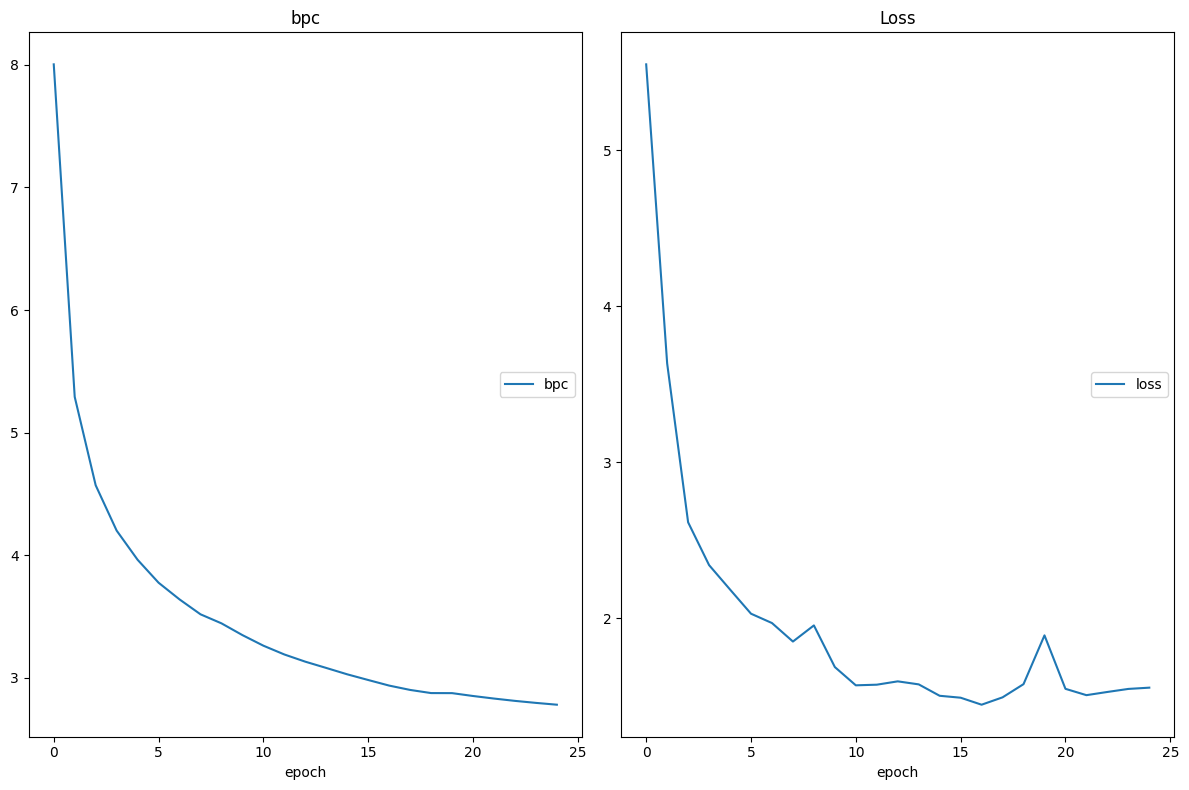

bpc
	bpc              	 (min:    2.779, max:    8.004, cur:    2.779)
Loss
	loss             	 (min:    1.444, max:    5.549, cur:    1.554)
epoch: 4800, loss: 1.553591251373291, bpc: 2.77935791015625


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_bpc,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
epoch,4800
lr,0.001
train_bpc,2.77936
train_loss,1.55359


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Language Modelling with Transformers",

    # track hyperparameters and run metadata
    config={
    "batch_size": 0.02,
    "seq_length": 128,
    "d_m": 64,
    "num_heads": 4,
    "num_layers_list": 1,
    "ff_widening_factor": 4,
    "LR": 2e-3,
    "dropout_rate": 0.1
    }
)

plotlosses = PlotLosses()

MAX_STEPS = 5000
LOG_EVERY = 200
losses = []
bpcs = []
VOCAB_SIZE = train_dataset.vocab_size

# Training loop
for epoch in range(MAX_STEPS):
    batch = next(train_dataset)
    params, optimizer_state, loss, bpc = train_step(
        params, optimizer_state, batch, key, lm.apply, optimizer.update)
    losses.append(loss)
    bpcs.append(bpc)
    if epoch % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        bpc_ = jnp.array(bpcs).mean()
        plotlosses.update(
            {
                "loss": loss_,
                 "bpc": bpc_,
            }
        )
        wandb.log({
            "train_loss": loss_,
            "train_bpc": bpc_,
            "epoch": epoch,
            "lr": LR,
            })
        plotlosses.send()
        losses = []
        print(f"epoch: {epoch}, loss: {loss_}, bpc: {bpc_}")

wandb.finish()


In [ ]:
lm = LM(num_heads=num_heads,
            num_layers=num_layers,
            d_m=d_m,
            vocab_size=vocab_size,
            ff_widening_factor=ff_widening_factor,
            dropout_rate = dropout_rate,
            training=False,
            pre_norm = pre_norm,
            tie_weights=tie_weights
      )

# Reinitialize test dataset with the best batch size and sequence length
test_dataset = CharacterBasedAsciiDatasetForLLM("nchlt_text.xh.test", batch_size, seq_length)

# Evaluate on all batches in the test dataset
test_losses = []
test_bpcs = []
for batch_idx in range(len(test_dataset)):
    print(f"Evaluating batch {batch_idx + 1}/{len(test_dataset)}")
    test_batch = next(test_dataset)
    mask = jnp.tril(jnp.ones((test_batch['input'].shape[1], test_batch['input'].shape[1])))
    key, test_key = jax.random.split(key)
    test_loss, test_bpc = validation_step(params, test_batch, mask, test_key, lm.apply)
    test_losses.append(test_loss)
    test_bpcs.append(test_bpc)

# Compute average test loss and BPC across all batches
avg_test_loss = jnp.mean(jnp.array(test_losses))
avg_test_bpc = jnp.mean(jnp.array(test_bpcs))

# Final Test BPC and Loss log
print("================================================================================")
print(f"| End of training | test loss {avg_test_loss} | test bpc {avg_test_bpc} ")
print("================================================================================")


Evaluating batch 1/124
Evaluating batch 2/124
Evaluating batch 3/124
Evaluating batch 4/124
Evaluating batch 5/124
Evaluating batch 6/124
Evaluating batch 7/124
Evaluating batch 8/124
Evaluating batch 9/124
Evaluating batch 10/124
Evaluating batch 11/124
Evaluating batch 12/124
Evaluating batch 13/124
Evaluating batch 14/124
Evaluating batch 15/124
Evaluating batch 16/124
Evaluating batch 17/124
Evaluating batch 18/124
Evaluating batch 19/124
Evaluating batch 20/124
Evaluating batch 21/124
Evaluating batch 22/124
Evaluating batch 23/124
Evaluating batch 24/124
Evaluating batch 25/124
Evaluating batch 26/124
Evaluating batch 27/124
Evaluating batch 28/124
Evaluating batch 29/124
Evaluating batch 30/124
Evaluating batch 31/124
Evaluating batch 32/124
Evaluating batch 33/124
Evaluating batch 34/124
Evaluating batch 35/124
Evaluating batch 36/124
Evaluating batch 37/124
Evaluating batch 38/124
Evaluating batch 39/124
Evaluating batch 40/124
Evaluating batch 41/124
Evaluating batch 42/124
E

# Advanced **Extensions**